In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
from surprise import Reader, Dataset, SVD, model_selection, accuracy
from surprise.model_selection import GridSearchCV
from joblib import Parallel, delayed
import multiprocessing

In [4]:
reduced_books_users_ratings = pd.read_csv("data/clean/reduced_books_users_ratings.csv")

In [5]:
books_users_ratings = pd.read_csv("data/clean/books_users_ratings.csv")

In [6]:
user_item_rating = reduced_books_users_ratings[['user_id', 'unique_isbn', 'book_rating']]
user_item_rating.head()

,user_id,unique_isbn,book_rating
0,11676,044023722X,10
1,11676,044023722X,8
2,11676,0671537458,8
3,11676,0671537458,5
4,11676,0679776818,8


In [54]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(user_item_rating, reader)

In [55]:
# splitting into train and test
train_data, test_data = model_selection.train_test_split(data, test_size=0.2)

In [10]:
param_grid = {'n_factors': [80, 100, 120], 'lr_all': [0.001, 0.005, 0.01], 'reg_all': [0.01, 0.02, 0.04]}

# Optimize SVD algorithm for both root mean squared error ('rmse') and mean average error ('mae')
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

In [11]:
# Fit the gridsearch result on the entire dataset
%time gs.fit(data)

CPU times: user 4min 36s, sys: 3.54 s, total: 4min 40s
Wall time: 4min 49s


In [83]:
# Return the best version of the SVD algorithm
model = gs.best_estimator['rmse']
print("SVD : Train Set")
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

SVD : Train Set
1.571631504460259
{'n_factors': 80, 'lr_all': 0.005, 'reg_all': 0.04}


In [13]:
%time model_selection.cross_validate(model, data, measures=['rmse', 'mae'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5674  1.5807  1.5764  1.5634  1.5705  1.5717  0.0062  
MAE (testset)     1.2103  1.2210  1.2108  1.2065  1.2129  1.2123  0.0048  
Fit time          4.67    4.31    3.99    3.92    3.93    4.16    0.29    
Test time         0.14    0.13    0.13    0.21    0.21    0.16    0.04    
CPU times: user 22.8 s, sys: 168 ms, total: 22.9 s
Wall time: 23 s


{'test_rmse': array([1.56744588, 1.58074355, 1.57641501, 1.56339161, 1.57048343]),
 'test_mae': array([1.2103069 , 1.22097135, 1.21084417, 1.20648728, 1.2129418 ]),
 'fit_time': (4.67155385017395,
  4.3136162757873535,
  3.987733840942383,
  3.9196579456329346,
  3.9300460815429688),
 'test_time': (0.136749267578125,
  0.12555909156799316,
  0.12606501579284668,
  0.21379685401916504,
  0.21386218070983887)}

In [14]:
# Use the new parameters with the training set
model = SVD(n_factors=80, lr_all=0.005, reg_all=0.04)
model.fit(train_data) # re-fit on only the training data using the best hyperparameters
test_pred = model.test(test_data)
print("SVD : Test Set")
accuracy.rmse(test_pred, verbose=True)

SVD : Test Set
RMSE: 1.5708


1.5707678866750148

# Parameter Relationships
`try_param` takes a dictionary of parameters with one parameter changing while the rest are held constant. The output is a data frame. The function runs in parallel and selects the minimum cores between the parameter sets (how many iterations are performed) and the number of cores available on the machine.

In [66]:
def try_param(param_grid, param):
    num_cores = multiprocessing.cpu_count()
    length_dict = {key: len(value) for key, value in param_grid.items()}
    max_length = max(length_dict.values())
    for key, value in param_grid.items():
        if len(value) == 1:
            param_grid[key] = list(np.repeat(value[0], max_length))
    param_sets = list(zip(*param_grid.values()))
    if param == "n_factors":
        p_indx = 0
    elif param == "lr_all":
        p_indx = 1
    else:
        p_indx = 2
    r = Parallel(n_jobs=min(len(param_sets), num_cores))(delayed(fit_model_return)(param_set, param, p_indx) for param_set in param_sets)            
    return(pd.DataFrame(r))

In [65]:
def fit_model_return(param_set, param, p_indx):
    model = SVD(n_factors=param_set[0], lr_all=param_set[1], reg_all=param_set[2])
    model.fit(train_data) # re-fit on only the training data using the best hyperparameters
    test_pred = model.test(test_data)
    rmse = (accuracy.rmse(test_pred, verbose=True))
    results_dict = {"parameter": param, "value": param_set[p_indx], "rmse": rmse}
    return(results_dict)

In [63]:
test_pred = model.test(test_data)
(accuracy.rmse(test_pred, verbose=True))

RMSE: 1.5682


1.568231355660561

In [22]:
param_grid = {'n_factors': list(range(50, 200, 5)), 'lr_all': [.005], 'reg_all': [0.04]}
param_grid

{'n_factors': [50,
  55,
  60,
  65,
  70,
  75,
  80,
  85,
  90,
  95,
  100,
  105,
  110,
  115,
  120,
  125,
  130,
  135,
  140,
  145,
  150,
  155,
  160,
  165,
  170,
  175,
  180,
  185,
  190,
  195],
 'lr_all': [0.005],
 'reg_all': [0.04]}

In [67]:
%time param_results = try_param(param_grid, "n_factors")

CPU times: user 59.2 s, sys: 574 ms, total: 59.7 s
Wall time: 1min 9s


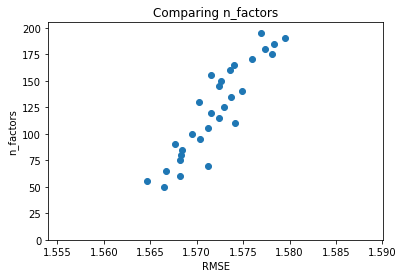

In [78]:
fig = plt.scatter(param_results.rmse, param_results.value)
plt.title(f"Comparing {param_results.parameter[0]}")
plt.ylim([0, max(param_results.value) + 2 * (list(param_results.value)[-1] - list(param_results.value)[-2])])
plt.xlabel("RMSE")
plt.ylabel(param_results.parameter[0])
plt.show()

# Print Recommendations

In [80]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

In [81]:
def get_reading_list(userid, predictions):
    """
    Retrieve full book titles from full 'books_users_ratings' dataframe
    """
    reading_list = defaultdict(list)
    top_n = get_top_n(predictions, n=10)
    for n in top_n[userid]:
        book, rating = n
        title = books_users_ratings.loc[books_users_ratings.unique_isbn == book].book_title.unique()[0]
        reading_list[title] = rating
    return reading_list

In [82]:
get_reading_list(111637, test_pred)

defaultdict(list,
            {'morality for beautiful girls (no.1 ladies detective agency)': 7.796701654522468,
             "the no. 1 ladies' detective agency (today show book club #8)": 7.149651295613182,
             "a cup of tea (ballantine reader's circle)": 6.765917809313971,
             'falling angels': 6.67336722933543})